<a href="https://colab.research.google.com/github/gilsonauerswald/Bioinformatic_Projects/blob/main/N_integration_across_multiple_%60omics_data_sets_with_DIABLO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study of DIABLO with Breast TCGA Dataset**
The aim of this N-integration analysis is to identify a highly correlated multi-omics signature that discriminates the breast cancer subtypes Basal, Her2 and LumA.

The full data set for this example (also including methylation data and 4 breast cancer subtypes) can be downloaded [here](http://mixomics.org/wp-content/uploads/2016/08/TCGA.normalised.mixDIABLO.RData_.zip). The example below illustrates an analysis on a smaller data set that is stored in the mixOmics package.

# **We First load mixOmics:**

In [ ]:
install.packages("BiocManager")
BiocManager::install("mixOmics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'mixOmics'

also installing the dependencies ‘formatR’, ‘RcppEigen’, ‘lambda.r’, ‘futile.options’, ‘plyr’, ‘Rcpp’, ‘RSpectra’, ‘futile.logger’, ‘snow’, ‘BH’, ‘igraph’, ‘ellipse’, ‘corpcor’, ‘reshape2’, ‘matrixStats’, ‘rARPACK’, ‘gridExtra’, ‘ggrepel’, ‘BiocParallel’


Old packages: 'backports', 'bit', 'brio', 'broom', 'bslib', 'cachem', 'callr',
  'cli', 'crayon', 'curl', 'data.table', 'DBI', 'dbplyr', 'devtools', 'digest',
  'evaluate', 'farver', 'fastmap', 'fs', 'gargle', 'ggplot2', 'gh', 'gtable',
  'highr', 'htmltools', 'httr2', 'isoband', 'knitr', 'munsell', 'openssl',
  'pkgbuild', 'pkgload', 'processx'

In [ ]:
library(mixOmics)

Loading required package: MASS

Loading required package: lattice

Loading required package: ggplot2


Loaded mixOmics 6.28.0
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')




# **Load Data**

In [ ]:
data('breast.TCGA')
# extract training data
data = list(mRNA = breast.TCGA$data.train$mrna,
            miRNA = breast.TCGA$data.train$mirna,
            proteomics = breast.TCGA$data.train$protein)

# check dimension
lapply(data, dim)

# outcome
Y = breast.TCGA$data.train$subtype
summary(Y)

$mRNA
[1] 150 200

$miRNA
[1] 150 184

$proteomics
[1] 150 142

Basal  Her2  LumA 
   45    30    75

# **Parameter choice**
Here we choose a design where all blocks (data sets) are connected with a link of 0.1.

In [ ]:
design = matrix(0.1, ncol = length(data), nrow = length(data),
                dimnames = list(names(data), names(data)))
diag(design) = 0
design

,mRNA,miRNA,proteomics
mRNA,0.0,0.1,0.1
miRNA,0.1,0.0,0.1
proteomics,0.1,0.1,0.0


First, we fit a DIABLO model without variable selection to assess the global performance and
choose the number of components for the final DIABLO model. The function perf is run with
10-fold cross validation repeated 10 times.
The elapsed reuning time is reported in seconds.

In [ ]:
sgccda.res = block.splsda(X = data, Y = Y, ncomp = 5,
                           design = design)

set.seed(123) # for reproducibility, only when the `cpus' argument is not used
t1 = proc.time()
perf.diablo = perf(sgccda.res, validation = 'Mfold', folds = 10, nrepeat = 10)
t2 = proc.time()
running_time = t2 - t1; running_time

Design matrix has changed to include Y; each block will be
            linked to Y.



   user  system elapsed 
 67.192   0.087  67.858 

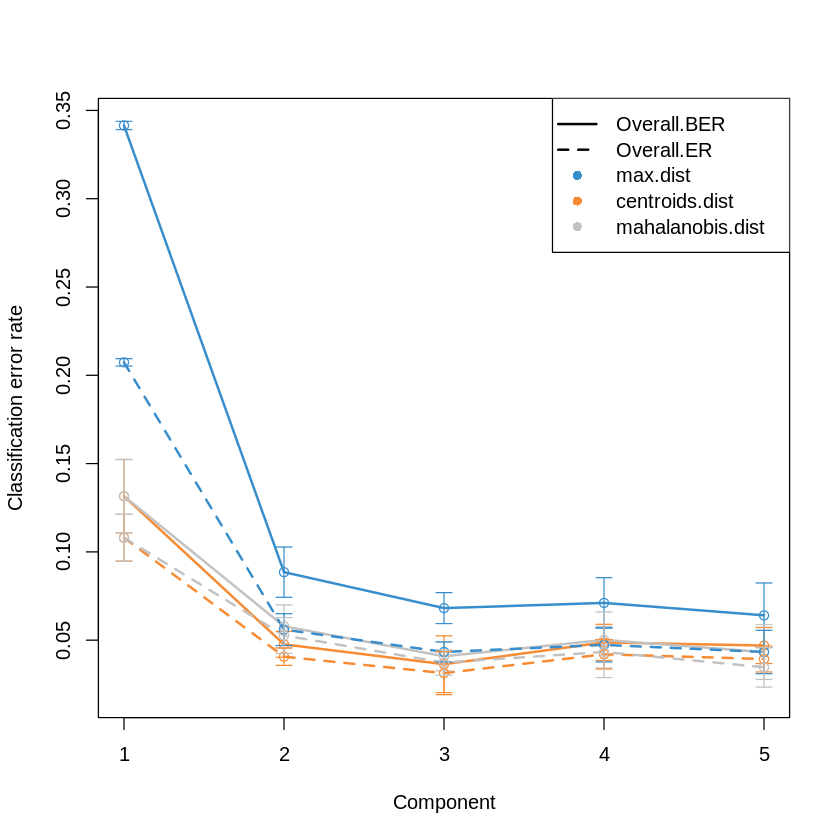

In [ ]:
#perf.diablo  # lists the different outputs
plot(perf.diablo)

Considering this distance and the BER, the output $choice.ncomp
indicates an optimal number of components = 2 for the final DIABLO model.

In [ ]:
perf.diablo$choice.ncomp$WeightedVote

,max.dist,centroids.dist,mahalanobis.dist
Overall.ER,3,2,3
Overall.BER,3,2,3


In [ ]:
ncomp = perf.diablo$choice.ncomp$WeightedVote["Overall.BER", "centroids.dist"]

Now that the number of components is chosen, the next step is to choose the optimal number
of variables to select in each data set using the tune.block.splsda function. We provide a grid
of keepX values for each type of `omics. Note that we set the grid to favour a small (but not too
small) signature while allowing to obtain a suficient number of variables for downstream validation
/ interpretation.

In [ ]:
# Install and load the BiocParallel package if not already installed
if (!requireNamespace("BiocParallel", quietly = TRUE)) {
    BiocManager::install("BiocParallel")
}
library(BiocParallel)

# Set up parallel backend with 2 cores
BPPARAM <- MulticoreParam(workers = 2)

In [ ]:
set.seed(123) # for reproducibility, only when the `cpus' argument is not used
test.keepX = list (mRNA = c(5:9, seq(10, 18, 2), seq(20,30,5)),
                    miRNA = c(5:9, seq(10, 18, 2), seq(20,30,5)),
                    proteomics = c(5:9, seq(10, 18, 2), seq(20,30,5)))

t1 = proc.time()
tune.TCGA = tune.block.splsda(X = data, Y = Y, ncomp = ncomp,
                               test.keepX = test.keepX, design = design,
                               validation = 'Mfold', folds = 10, nrepeat = 1,
                               BPPARAM = BPPARAM, dist = "centroids.dist")

Design matrix has changed to include Y; each block will be
            linked to Y.


You have provided a sequence of keepX of length: 13 for block mRNA and 13 for block miRNA and 13 for block proteomics.
This results in 2197 models being fitted for each component and each nrepeat, this may take some time to run, be patient!



The number of features to select on each component is returned in tune.TCGA$choice.keepX:

In [ ]:
list.keepX = tune.TCGA$choice.keepX
tune.TCGA$choice.keepX

$mRNA
[1]  8 25

$miRNA
[1] 14  5

$proteomics
[1] 10  5

# **Final model**
The final DIABLO model is run as:

In [ ]:
sgccda.res = block.splsda(X = data, Y = Y, ncomp = ncomp,
                          keepX = list.keepX, design = design)

Design matrix has changed to include Y; each block will be
            linked to Y.



The warning message informs that the outcome Y has been included automatically in the design,
so that the covariance between each block's component and the outcome is maximised, as shown in
the final design output:

In [ ]:
sgccda.res$design

,mRNA,miRNA,proteomics,Y
mRNA,0.0,0.1,0.1,1
miRNA,0.1,0.0,0.1,1
proteomics,0.1,0.1,0.0,1
Y,1.0,1.0,1.0,0


The selected variables can be extracted with the function selectVar, for example in the mRNA
block, along with their loading weights:

In [ ]:
# mRNA variables selected on component 1
selectVar(sgccda.res, block = 'mRNA', comp = 1)$mRNA$name

[1] "ZNF552"  "KDM4B"   "CCNA2"   "LRIG1"   "PREX1"   "FUT8"    "C4orf34"
[8] "TTC39A"

## **Sample plots**
plotDIABLO is a diagnostic plot to check whether the correlation between components from each
data set was maximised as specified in the design matrix. We specify the dimension to be assessed
with the ncomp argument.

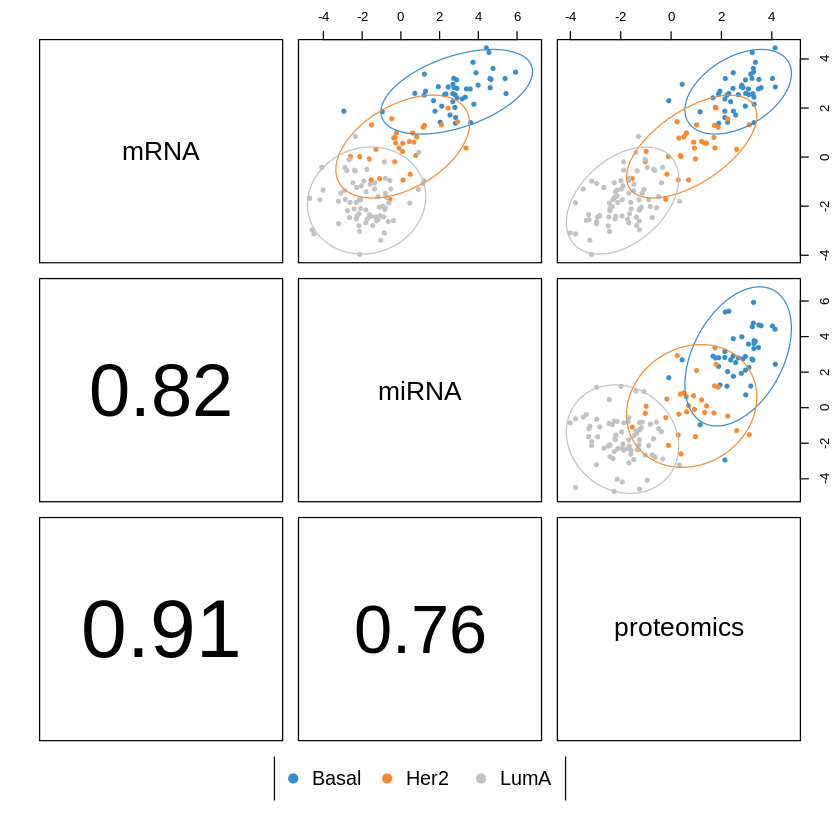

In [ ]:
plotDiablo(sgccda.res, ncomp = 1)

The sample plot with the plotIndiv function projects each sample into the space spanned by
the components from each block. The optional argument blocks can output a specific data set.
Ellipse plots are also available (argument ellipse = TRUE). This type of graphic allows us to better
understand the information extracted from each data set and its discriminative ability.

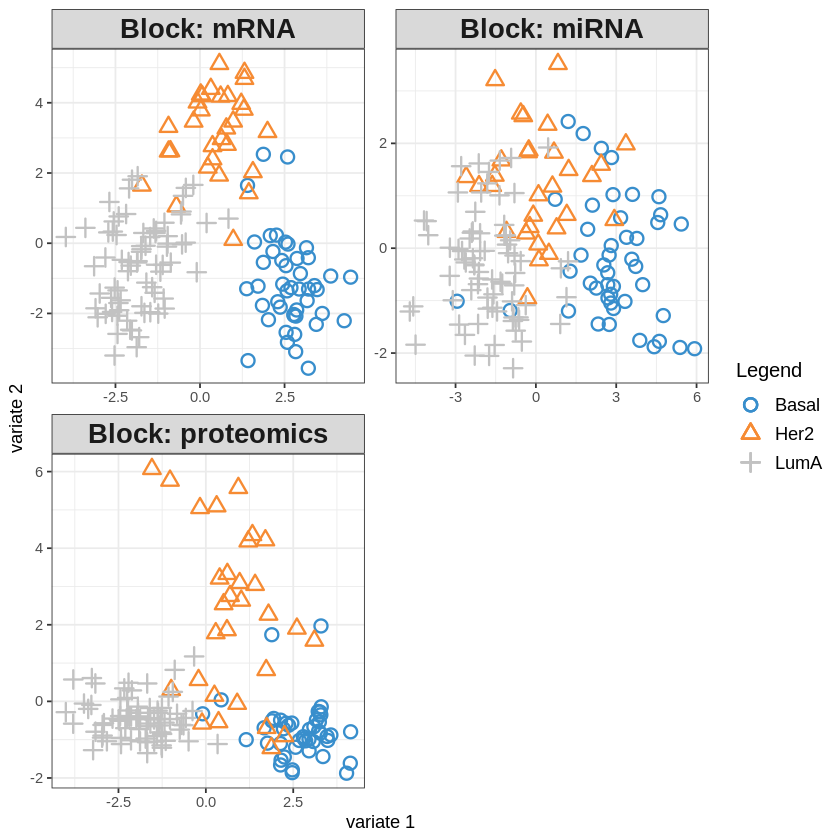

In [ ]:
plotIndiv(sgccda.res, ind.names = FALSE, legend = TRUE,  style="ggplot2")

In the arrow plot below, the start of the arrow indicates the centroid between all data sets for a
given sample and the tip of the arrow the location of the same sample in each block. Such graphic
highlights the agreement between all data sets at the sample level when modelled with DIABLO.

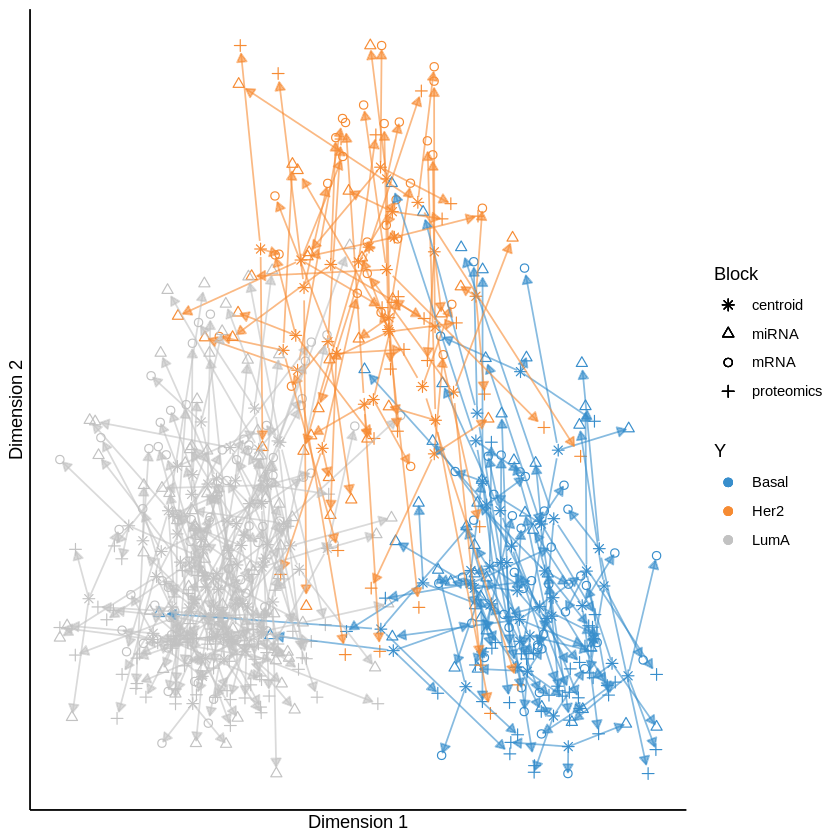

In [ ]:
plotArrow(sgccda.res, ind.names = FALSE, legend = TRUE, title = 'DIABLO')

## **Variable plots**
Several graphical outputs are available to visualise and mine the associations between the selected
variables.


The correlation circle plot highlights the contribution of each selected variable to each component.
Important variables should be close to the large circle, see Gonzalez et al. 2012 for more details.
plotVar displays the variables from all blocks, selected on component 1 and 2. Clusters of points
indicate a strong correlation between variables. For better visibility we choose to hide the variable
names.

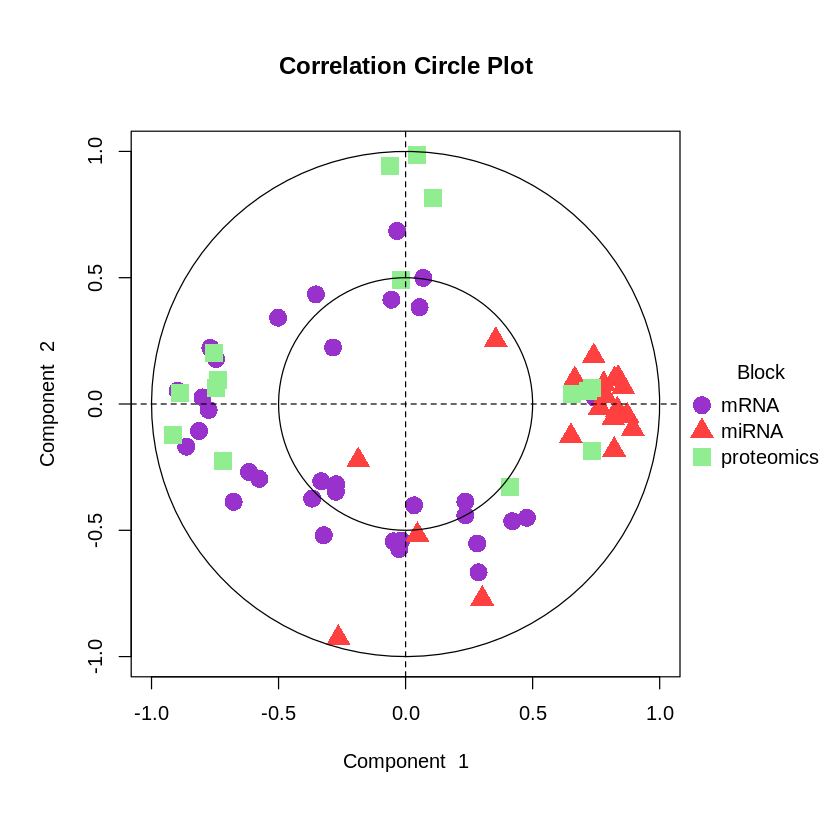

In [ ]:
plotVar(sgccda.res, var.names = FALSE, style = 'graphics', legend = TRUE,
        pch = c(16, 17, 15), cex = c(2,2,2), col = c('darkorchid', 'brown1', 'lightgreen'))

We can also only display the variables selected on a specific component, here component 1:

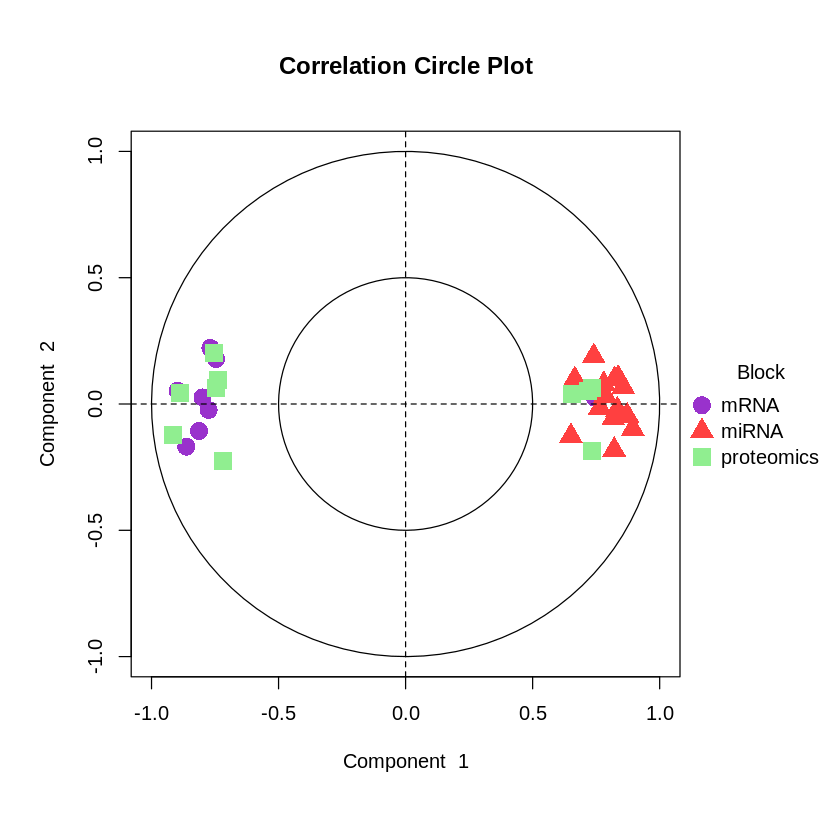

In [ ]:
plotVar(sgccda.res, var.names = FALSE, style = 'graphics', legend = TRUE,
        pch = c(16, 17, 15), cex = c(2,2,2), col = c('darkorchid', 'brown1', 'lightgreen'),
        comp.select = 1)

The circos plot represents the correlations between variables of different types, represented on
the side quadrants. Several display options are possible, to show within and between connexions
between blocks, expression levels of each variable according to each class (argument line = TRUE).
The circos plot is built based on a similarity matrix, which was extended to the case of multiple
data sets from Gonzalez et al. 2012.

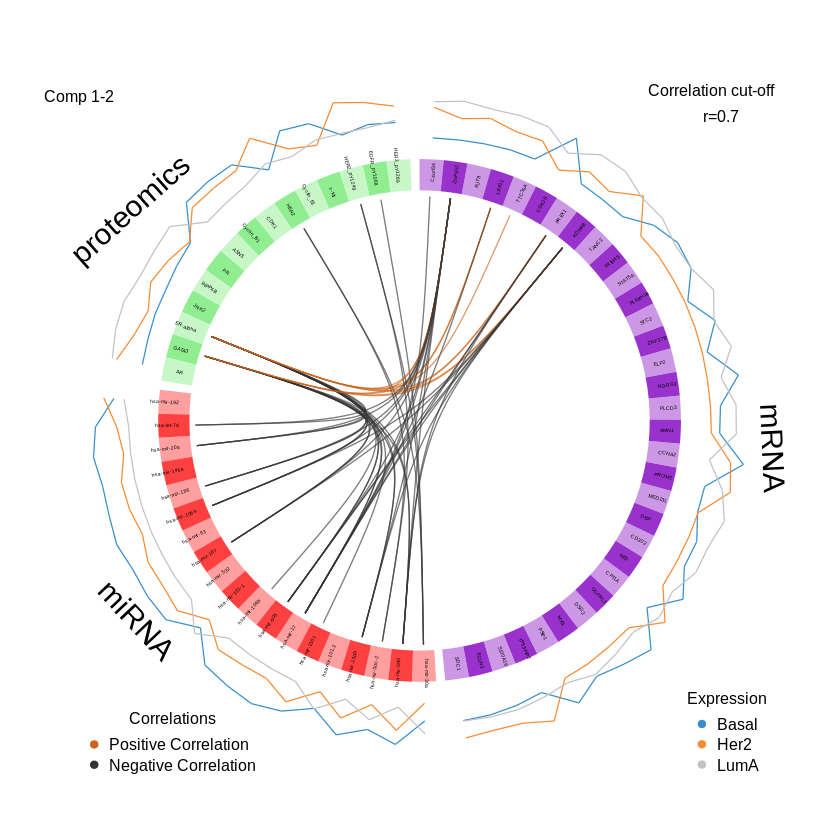

In [ ]:
circosPlot(sgccda.res, cutoff = 0.7, line = TRUE,
           color.blocks= c('darkorchid', 'brown1', 'lightgreen'),
           color.cor = c("chocolate3","grey20"), size.labels = 1.5)

Another visualisation of the correlation between the different types of variables is the relevance
network, which is also built on the similarity matrix. Each color represents a type of variable. A
threshold can also be set using the argument cutoff.

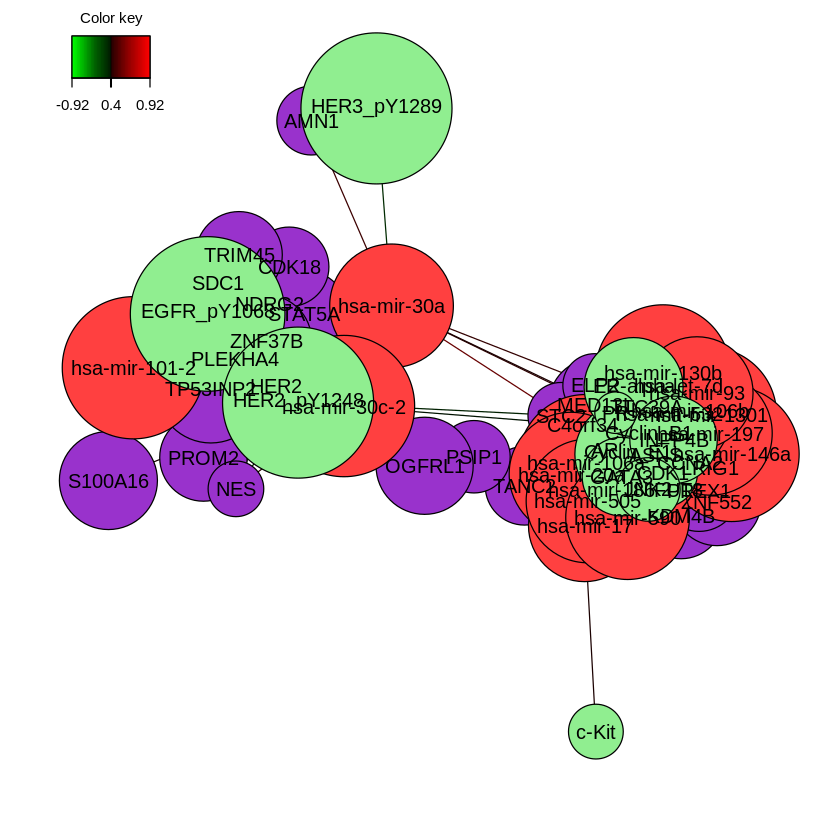

In [ ]:
network(sgccda.res, blocks = c(1,2,3),
        color.node = c('darkorchid', 'brown1', 'lightgreen'), cutoff = 0.4)

The network can be saved in a .gml format to be input into the software Cytoscape, using the R
package igraph

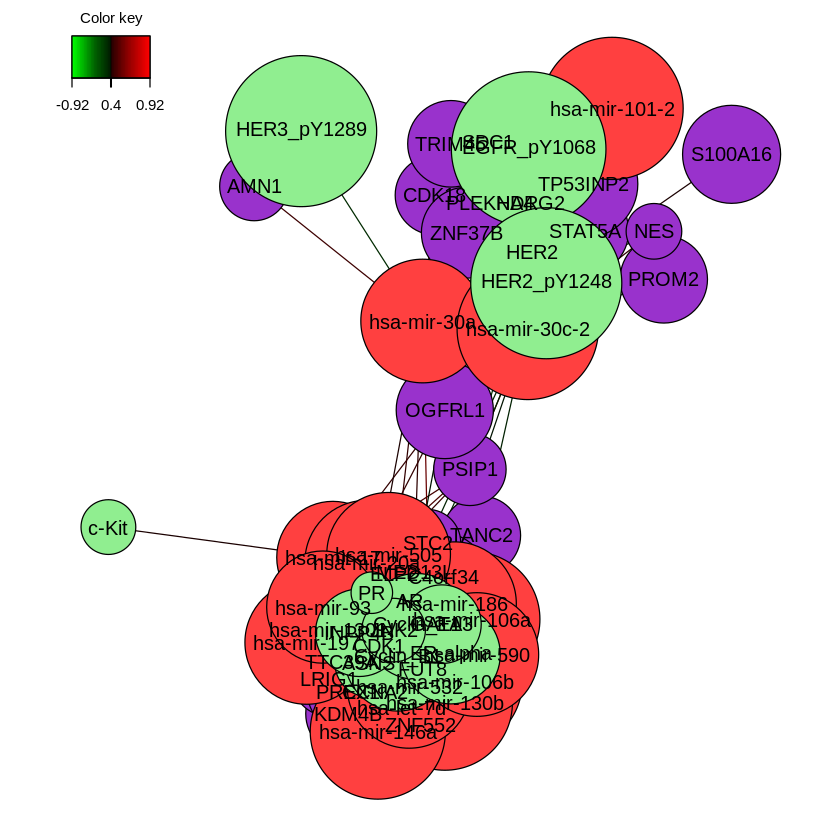

In [ ]:
library(igraph)
my.network = network(sgccda.res, blocks = c(1,2,3),
         color.node = c('darkorchid', 'brown1', 'lightgreen'), cutoff = 0.4)
write_graph(my.network$gR, file = "myNetwork.gml", format = "gml")

plotLoadings visualises the loading weights of each selected variables on each component and
each data set. The color indicates the class in which the variable has the maximum level of expression
(contrib = 'max') or minimum (contrib = `min'), on average (method = `mean') or using the
median (method = `median').

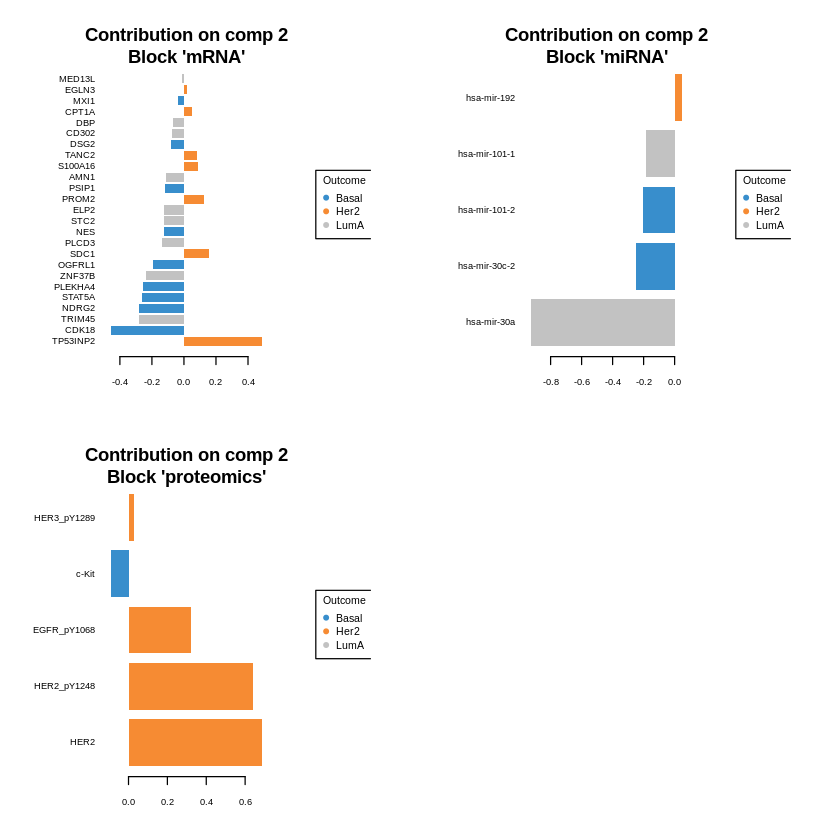

In [ ]:
plotLoadings(sgccda.res, comp = 2, contrib = 'max', method = 'median')

The cimDiablo function is a clustered image map specifically implemented to represent the
multi-`omics molecular signature expression for each sample.


trimming values to [-3, 3] range for cim visualisation. See 'trim' arg in ?cimDiablo


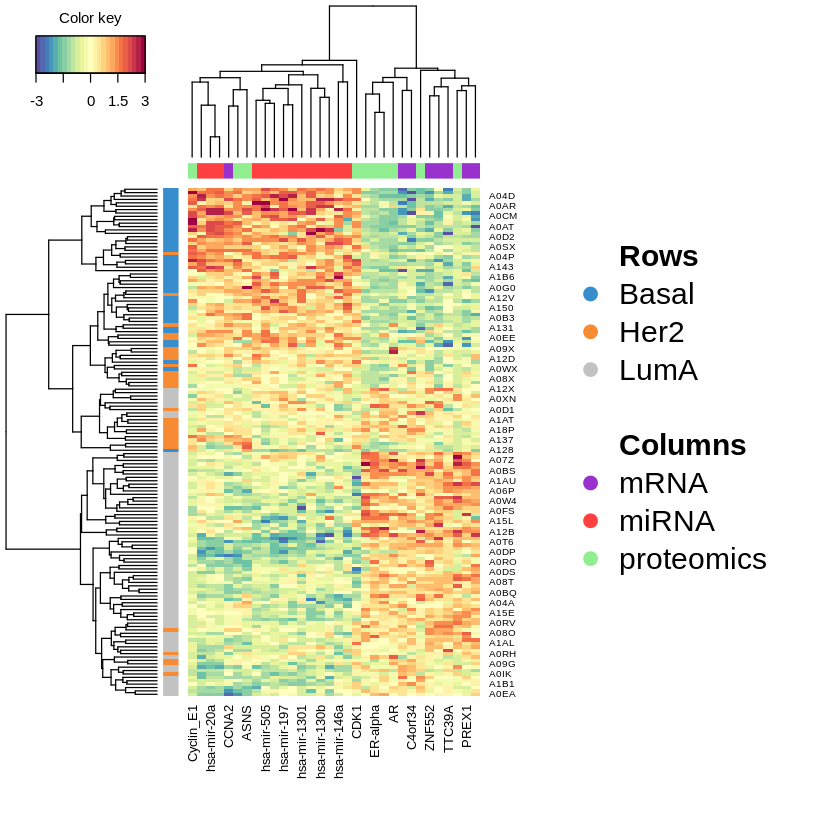

In [ ]:
cimDiablo(sgccda.res, color.blocks = c('darkorchid', 'brown1', 'lightgreen'),
          comp = 1, margin=c(8,20), legend.position = "right")

# **Performance of the model**
We assess the performance of the model using 10-fold cross-validation repeated 10 times with the
function perf. The method runs a block.splsda model on the pre-specified arguments input from
our sgccda.res object but on cross-validated samples. We then assess the accuracy of the prediction
on the left out samples.

In [ ]:
set.seed(123) # for reproducibility, only when the `cpus' argument is not used
t1 = proc.time()
perf.diablo = perf(sgccda.res, validation = 'Mfold', folds = 10, nrepeat = 10,
                   dist = 'centroids.dist')
t2 = proc.time()
running_time = t2 - t1; running_time

   user  system elapsed 
 27.679   0.057  27.933 

## **ERROR Rate**

In [ ]:
# Performance with Majority vote
perf.diablo$MajorityVote.error.rate

# Performance with Weighted vote
perf.diablo$WeightedVote.error.rate

,comp1,comp2
Basal,0.02666667,0.04444444
Her2,0.20666667,0.12333333
LumA,0.04533333,0.00800000
Overall.ER,0.07200000,0.04200000
Overall.BER,0.09288889,0.05859259


,comp1,comp2
Basal,0.006666667,0.04444444
Her2,0.140000000,0.10666667
LumA,0.045333333,0.00800000
Overall.ER,0.052666667,0.03866667
Overall.BER,0.064000000,0.05303704


## **AUC plot**
An AUC plot per block is plotted using the function auroc, refer to Rohart et al. 2017 for the
interpretation of such output as the ROC and AUC criteria are not particularly insightful in relation
to the performance evaluation of our methods, but can complement the statistical analysis.

$mRNA
$mRNA$comp1
                     AUC p-value
Basal vs Other(s) 0.9972 0.00000
Her2 vs Other(s)  0.6019 0.08465
LumA vs Other(s)  0.9829 0.00000

$mRNA$comp2
                     AUC   p-value
Basal vs Other(s) 0.9983 0.000e+00
Her2 vs Other(s)  0.9822 4.441e-16
LumA vs Other(s)  0.9938 0.000e+00


$miRNA
$miRNA$comp1
                     AUC p-value
Basal vs Other(s) 0.9528   0.000
Her2 vs Other(s)  0.5692   0.242
LumA vs Other(s)  0.9246   0.000

$miRNA$comp2
                     AUC  p-value
Basal vs Other(s) 0.9596 0.00e+00
Her2 vs Other(s)  0.8606 1.07e-09
LumA vs Other(s)  0.9564 0.00e+00


$proteomics
$proteomics$comp1
                     AUC p-value
Basal vs Other(s) 0.9765 0.00000
Her2 vs Other(s)  0.6353 0.02213
LumA vs Other(s)  0.9868 0.00000

$proteomics$comp2
                     AUC   p-value
Basal vs Other(s) 0.9875 0.000e+00
Her2 vs Other(s)  0.9139 2.548e-12
LumA vs Other(s)  0.9970 0.000e+00




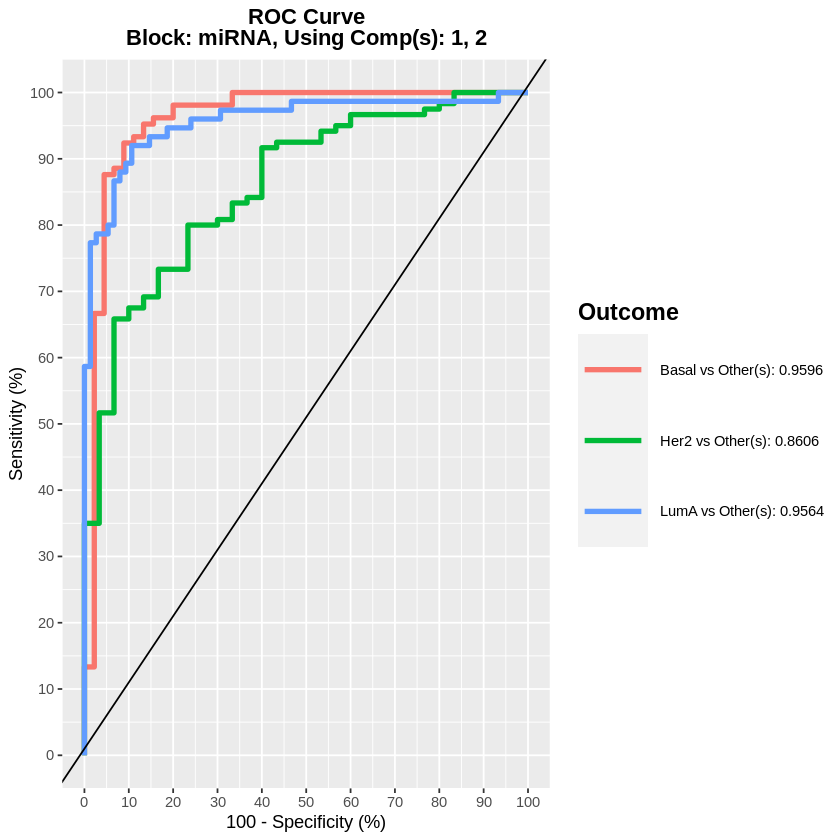

In [ ]:
auc.diablo = auroc(sgccda.res, roc.block = "miRNA", roc.comp = 2)

## **Prediction on an external test set.**
The predict function predicts the class of samples from a test set. In our specific case, one data set
is missing in the test set but the method can still be applied. Make sure the name of the blocks
correspond exactly.

In [ ]:
# prepare test set data: here one block (proteins) is missing
data.test.TCGA = list(mRNA = breast.TCGA$data.test$mrna,
                      miRNA = breast.TCGA$data.test$mirna)

predict.diablo = predict(sgccda.res, newdata = data.test.TCGA)

Warning message in predict.block.spls(sgccda.res, newdata = data.test.TCGA):
“Some blocks are missing in 'newdata'; the prediction is based on the following blocks only: mRNA, miRNA”


The confusion table compares the real subtypes with the predicted subtypes for a 2 component
model, for the distance of interest:

In [ ]:
confusion.mat = get.confusion_matrix(truth = breast.TCGA$data.test$subtype,
                     predicted = predict.diablo$WeightedVote$centroids.dist[,2])
confusion.mat
get.BER(confusion.mat)

,predicted.as.Basal,predicted.as.Her2,predicted.as.LumA
Basal,20,1,0
Her2,0,13,1
LumA,0,3,32


[1] 0.06825397